In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = True
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

from util import cst
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow_probability import distributions
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras import backend as k

# Load data
data_folder = '/app/data'
data = cst.load_cmapss_data(data_folder)

# Identify input columns
dt_in = list(data.columns[3:-1])

# Lagrangian Approaches for Knowledge Injection

When soft constraints are enough

## Constrained Machine Learning

**Let's consider ML problem with _constrained output_**

In particular, let's focus on problems in the form:
$$
\arg\min_{\theta} \left\{ L({\bf y}) \mid g({\bf y}) \leq {\bf 0} \right\} \text{ with: } {\bf y} = f({\bf x}; \theta)
$$
Where:
* $L$ is the loss
* ${\bf x}$ is the training input
* ${\bf y}$ is the ML model output, i.e. $f({\bf x}; \theta)$
* $\theta$ is the parameter vector (we assume a parameterized model)
* $g$ is a constraint function

Equality csts. can be viewed as double-inequalities (but they admit simplifications)


## Constrained Machine Learning

**Example 1: _logical rules_**

E.g. hiearchies in multi-class classification ("A dog is also an animal"):
$$
y_{i,dog} \leq y_{i,animal}
$$
* This constraint is defined over _individual examples_

**Example 2: shape constraints**

E.g. input $x_j$ cannot cause the output to decrease (monotonicity)
$$
y_{i} \leq y_{k} \quad \forall i, k : x_{i,j} \leq x_{k,j} \wedge x_{i,h} = x_{k,h} \forall h \neq j
$$
* This is a _relational constraint_, i.e. defined over multiple examples

## Lagrangian Relaxations for Constrained ML

**One way to deal with this problem is to rely on a _Lagrangian Relaxation_**

Main idea: we turn the constraints into _penalty terms_:
$$
\arg\min_{\theta} \left\{ L({\bf y}) + \lambda^T \max(0, g({\bf y})) \right\} \text{ with: } {\bf y} = f({\bf x}; \theta)
$$
* We use a vector of multipliers $\lambda$ to weight the constraint violations

**Sometimes, penalties are squared:**
$$
\arg\min_{\theta} \left\{ L({\bf y}) + \lambda^T \max(0, g({\bf y}))^2 \right\} \text{ with: } {\bf y} = f({\bf x}; \theta)
$$

**This is a popular approach for ML with constraints**

* One of the first occurrences as _Semantic Based Regularization_ [1]
* The constraints are "distilled" in the model parameters
* ...I.e. the model _learns to satisfy_ the constraints



## Lagrangian Relaxations for Constrained ML

**Equality constraints can be treated as double inequalities**

...Or via the simplified form:
$$
\arg\min_{\theta} \left\{ L({\bf y}) + \lambda^T g({\bf y})^2 \right\} \text{ with: } {\bf y} = f({\bf x}; \theta)
$$


**There are a few big caveats**

The one we care about now is that:

* The degree of constraint satisfaction depends on the multipliers
* There is no trivial guarantee that constraints are eventually satisfied

> **..But neither point matters if our goal is simply to _inject some expert knowledge_**

# A Case Study: Scarce Label in Predictive Maintenance

## Scarce Labels in RUL Predictions

**RUL estimation is a major goal for predictive maintenance**

However, ground truth for RUL is hard to come by:

* Run-to-failure experiments are time consuming
* They may not be viable for large and complex machines
* Typically, _only a few runs_ are available

**However, data about _normal_ operation may still be abundant**

* This may come from test runs, installed machines, etc.
* It looks exactly like the input data for our RUL prediction model
* ...And it will still show sign of component wear

However, _the true RUL value in this case will be unknown_

> **Can we still take advantage of this data?**

# Our Baseline Approach

## Data Loading and Preparation

**We will rely on the [NASA C-MAPPS dataset](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/)**

...Which contains simulated run-to-failure experiments for turbo-fan engines

In [2]:
data.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD001,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,train_FD001,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,train_FD001,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,train_FD001,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,train_FD001,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


* There are three sub-datasets (column `src`)
* Each corresponds to different fault types and operating conditions
* Columns `p1-3` represent control parameters
* Columns `s1-21` are sensor readings

## Data Loading and Preparation

**We will focus on the FD004 dataset**

...Which is the most general and complex case

In [3]:
data_by_src = cst.split_by_field(data, field='src')
dt = data_by_src['train_FD004']
dt[dt_in] = dt[dt_in].astype(np.float32)

We then simulate the scarcity of run-to-failure experiments:

In [5]:
trs_ratio = 0.03 # Ratio of supervised experiments
tru_ratio = 0.75 # Ration of supervised and unsupervised data

np.random.seed(42)
machines = dt.machine.unique()
np.random.shuffle(machines)

sep_trs = int(trs_ratio * len(machines))
sep_tru = int(tru_ratio * len(machines))

trs_mcn = list(machines[:sep_trs])
tru_mcn = list(machines[sep_trs:sep_tru])
ts_mcn = list(machines[sep_tru:])

## Data Loading and Preparation

**Let's check how many machines/experiments we have in each group**

In [6]:
print(f'Num. machine: {len(trs_mcn)} (supervised), {len(tru_mcn)} (unsupervised), {len(ts_mcn)} (test)')

Num. machine: 7 (supervised), 179 (unsupervised), 63 (test)


We can then splid the dataset according to this machine groups:

In [7]:
tr, ts = cst.partition_by_machine(dt, trs_mcn + tru_mcn)
trs, tru = cst.partition_by_machine(tr, trs_mcn)

Let's check the number of examples for each group:

In [8]:
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 1376 (supervised), 44009 (unsupervised), 15864 (test)


## Data Loading and Preparation

**Then we standardize the input data**

In [9]:
trmean = tr[dt_in].mean()
trstd = tr[dt_in].std().replace(to_replace=0, value=1) # handle static fields

ts_s = ts.copy()
ts_s[dt_in] = (ts_s[dt_in] - trmean) / trstd
tr_s = trs.copy()
tr_s[dt_in] = (tr_s[dt_in] - trmean) / trstd
trs_s = trs.copy()
trs_s[dt_in] = (trs_s[dt_in] - trmean) / trstd
tru_s = tru.copy()
tru_s[dt_in] = (tru_s[dt_in] - trmean) / trstd

**...And we normalize the RUL values**

In [10]:
trmaxrul = tr['rul'].max()

ts_s['rul'] = ts['rul'] / trmaxrul 
tr_s['rul'] = tr['rul'] / trmaxrul 
trs_s['rul'] = trs['rul'] / trmaxrul
tru_s['rul'] = tru['rul'] / trmaxrul

## MLP with Scarce Labels

**We can now train again a MLP model**

For reason that will be clearer later, we have wrapped the code in a class:

```python
class MLPRegressor(keras.Model):
    def __init__(self, input_shape, hidden=[]):
        super(MLPRegressor, self).__init__()
        self.lrs = [layers.Dense(h, activation='relu') for h in hidden]
        self.lrs.append(layers.Dense(1, activation='linear'))

    def call(self, data):
        x = data
        for layer in self.lrs: x = layer(x)
        return x
```

* We are subclassing `keras.Model` and inheriting all its methods
* The `__init__` method builds the necessary layers
* The `call` method computes the predictions

## MLP with Scarce Labels

**The model can be trained as usual for keras/tensorflow**

In [11]:
nn = cst.MLPRegressor(input_shape=len(dt_in), hidden=[32, 32])
nn.compile(optimizer='Adam', loss='mse')
history = nn.fit(trs_s[dt_in], trs_s['rul'], batch_size=32, epochs=20, verbose=1)

Epoch 1/20
43/43 [==============================] - 0s 914us/step - loss: 0.0658
Epoch 2/20
43/43 [==============================] - 0s 882us/step - loss: 0.0113
Epoch 3/20
43/43 [==============================] - 0s 1ms/step - loss: 0.0101
Epoch 4/20
43/43 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 5/20
43/43 [==============================] - 0s 911us/step - loss: 0.0098
Epoch 6/20
43/43 [==============================] - 0s 1ms/step - loss: 0.0088
Epoch 7/20
43/43 [==============================] - 0s 1ms/step - loss: 0.0085
Epoch 8/20
43/43 [==============================] - 0s 958us/step - loss: 0.0084
Epoch 9/20
43/43 [==============================] - 0s 1ms/step - loss: 0.0078
Epoch 10/20
43/43 [==============================] - 0s 983us/step - loss: 0.0073
Epoch 11/20
43/43 [==============================] - 0s 1ms/step - loss: 0.0070
Epoch 12/20
43/43 [==============================] - 0s 1ms/step - loss: 0.0068
Epoch 13/20
43/43 [====================

## Evaluation

**Let's inspect the predictions**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
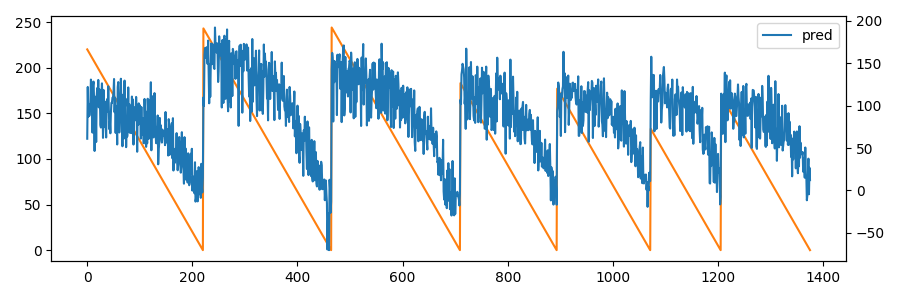

In [12]:
trs_pred = nn.predict(trs_s[dt_in]).ravel() * trmaxrul
stop = 1400 
cst.plot_rul(trs_pred[:stop], trs["rul"].iloc[:stop], same_scale=False, figsize=figsize)

* The predictions have a decreasing trend (which is good)
* ...But they are _very_ noisy

## Evaluation

**The behavior on the unsupervised data is very similar**

...And similarly noisy

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
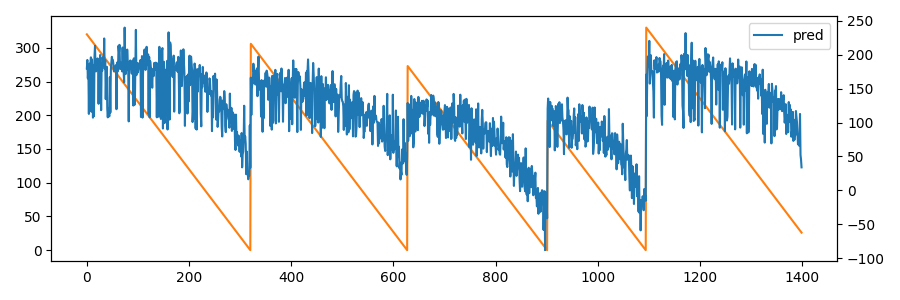

In [13]:
tru_pred = nn.predict(tru_s[dt_in]).ravel() * trmaxrul
cst.plot_rul(tru_pred[:stop], tru["rul"].iloc[:stop], same_scale=False, figsize=figsize)

## Evaluation

**The same goes for the data in the test set**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
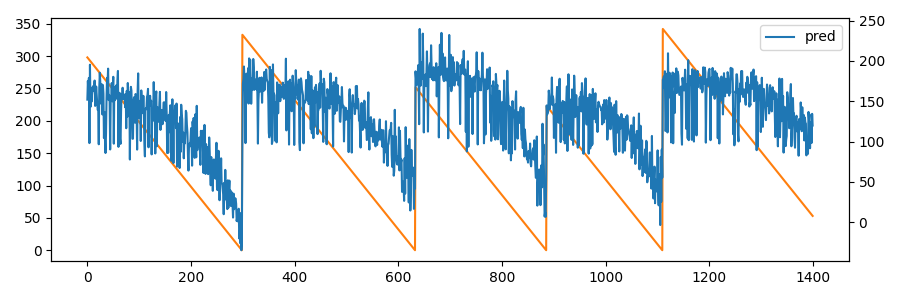

In [14]:
ts_pred = nn.predict(ts_s[dt_in]).ravel() * trmaxrul
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

## Cost Model

**The RUL estimator is meant to be used to define a policy**

Namely, we stop operations when:
$$
f(x; \theta) \leq \epsilon
$$
* Where $f(x; \theta)$ is the RUL estimator output
* ...And $\epsilon$ is threshold that needs to be calibrated

**Calibration is best done by relying on a cost model**

* We assume that operating for a time step generates 1 unit of profit
* ...And that failing looses $C$ units of profits w.r.t. performing maintenance
* We also assume we never stop a machine before a "safe" interval $s$

Both $C$ and $s$ are calibrated on data in our example:

In [15]:
failtimes = dt.groupby('machine')['cycle'].max() 
safe_interval, maintenance_cost = failtimes.min(), failtimes.max()

## Cost Model and Threshold Optimization

**We then proceed to choose $\epsilon$ to optimize the cost**

Optimal threshold for the training set: -11


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
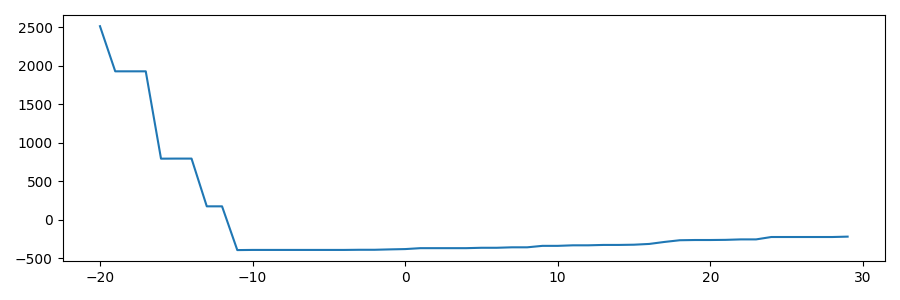

In [17]:
cmodel = cst.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(-20, 30)
trs_thr = cst.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {trs_thr}')

## Cost Results

**The cost on the training set is decent (negative)**

...But that is neither the case for the unsupervised experiments, nor for the test set

In [18]:
trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru_s['machine'].values, tru_pred, trs_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
print(f'Cost: {trs_c} (supervised), {tru_c} (unsupervised), {ts_c} (test)')

Cost: -396 (supervised), 38053 (unsupervised), 16792 (test)


In [19]:
trs_nm, tru_nm, ts_nm = len(trs_mcn), len(tru_mcn), len(ts_mcn)
print(f'Avg. fails: {trs_f/trs_nm:.2f} (supervised), {tru_f/tru_nm:.2f} (unsupervised), {ts_f/ts_nm:.2f} (test)')
print(f'Avg. slack: {trs_sl/trs_nm:.2f} (supervised), {tru_sl/tru_nm:.2f} (unsupervised), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.00 (supervised), 0.47 (unsupervised), 0.56 (test)
Avg. slack: 12.00 (supervised), 7.62 (unsupervised), 7.21 (test)


* In particular, there is a _very high failure rate on unseen data_

# Domain Knowledge as Constraints

## Domain Knowledge as Constraints

**We know that the RUL _decreases at a fixed rate_**

* After 1 time step, the RUL will have decreased by 1 unit
* After 2 time steps, the RUL will have decreased by 2 units and so on

**In general, let $\hat{x}_i$ and $\hat{x}_j$ be the $i$-th and $j$-th samples _for a given component_**

Then we know that:

$$\begin{align}
& f(\hat{x}_i, \theta) - f(\hat{x}_j, \theta) = j - i & \forall i, j = 1..m \text{ s.t. } c_i = c_j
\end{align}$$

* $c_i, c_j$ are the components for (respectively) sample $i$ and $j$
* Samples are assumed to be _temporally sorted_
* The left-most terms is the difference between the predicted RULs
* $j -i$ is the difference between the sequential indexes of the two samples
* ...Which by construction should be equal to the RUL difference

## Domain Knowledge as Constraints

**The relation we identified is a _constraint_**

$$\begin{align}
& f(\hat{x}_i, \theta) - f(\hat{x}_j, \theta) = j - i & \forall i, j = 1..m \text{ s.t. } c_i = c_j
\end{align}$$

It represents domain knowledge that should (in principle) hold for our problem

* It is fine to treat this as a _soft constraint_

**As a regularization term, we will use:**
$$
\lambda \left(f(\hat{x}_i, \omega) - f(\hat{x}_j, \omega) - (j-i)\right)^2
$$

Using the absolute value (h1 norm) may also work

* The constraint involves pairs of example, i.e. it is a _relational constraint_
* In principle we should consider all pairs, but that may scale poorly

## Our Regularizer

**We can focus on contiguous pairs, leading to the loss**

$$
L(\hat{x}, \omega) + \lambda \sum_{\substack{i \prec j \\ c_i = c_j}} \left(f(\hat{x}_i, \omega) - f(\hat{x}_j, \omega) - (j-i)\right)^2
$$

* Where $i \prec j$ iff $j$ is the next sample for after $i$ for a given machine 
* This approach requires a linear (rather than quadratic) number of constraints

**It can work with mini-batches**

* In this case, $\prec$ will refer to contiguous samples _in the same batch_
* ...And of course for the same component

**We will now see how to implement this approach**

## Removing RUL Values

**We start by preparing a bit more the unsupervised data**

* First, we _remove the end_ of the unsupervised data sequences
* This simulate the fact that the machines are still operating

In [20]:
tru_s_by_m = cst.split_by_field(tru_s, 'machine')
np.random.seed(42)
for mcn, tmp in tru_s_by_m.items():
    cutoff = int(np.random.randint(10, 50, 1))
    tru_s_by_m[mcn] = tmp.iloc[:-cutoff]
tru_st = pd.concat(tru_s_by_m.values())

Then we assign an invalid value to the RUL for unsupervised data:

In [21]:
trsu_s = pd.concat((trs_s, tru_st))
trsu_s.loc[tru_st.index, 'rul'] = -1

We also buid a single dataset containing both supervised and unsupervised data

## Generating Batches from the Same Machine

**Our SBR approach requires to have _sorted_ samples _from the same machine_**

The easiest way to ensure we have enough of them is using a custom `DataGenerator`


```python
class SMBatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, in_cols, batch_size, seed=42): ...

    def __len__(self): ...

    def __getitem__(self, index): ...

    def on_epoch_end(self): ...

    def __build_batches(self): ...
```

* `__len__` is called to know how many batches are left
* `__getitem__` should return one batch
* `on_epoch_end` should take care (e.g.) of shuffling

## Generating Batches from the Same Machine

**The `__init__` method takes care of the initial setup**

```python
def __init__(self, data, in_cols, batch_size, seed=42):
    super(SMBatchGenerator).__init__()
    self.data = data
    self.in_cols = in_cols
    self.dpm = split_by_field(data, 'machine')
    self.rng = np.random.default_rng(seed)
    self.batch_size = batch_size
    # Build the first sequence of batches
    self.__build_batches()
```

* We store some fields
* We split the data by machine
* We build a dedicated RNG
* ...And finally we call the custom-made `__build_batches` method

## Generating Batches from the Same Machine

**The `__build_batches` method prepares the batches for one full epoch**

```python
def __build_batches(self):
    self.batches, self.machines = [], []
    mcns = list(self.dpm.keys()) # sort the machines at random
    self.rng.shuffle(mcns)
    for mcn in mcns: # Loop over all machines
        index = self.dpm[mcn].index # sample indexes for this machine
        padsize = self.batch_size - (len(index) % self.batch_size)
        padding = self.rng.choice(index, padsize) # pad the last batch
        idx = np.hstack((index, padding))
        self.rng.shuffle(idx) # shuffle sample indexes for this machine
        bt = idx.reshape(-1, self.batch_size) # split into batches
        bt = np.sort(bt, axis=1) # sort every batch individually
        self.batches.append(bt) # store
        self.machines.append(np.repeat([mcn], len(bt)))
    self.batches = np.vstack(self.batches) # concatenate
    self.machines = np.hstack(self.machines)
```

## Generating Batches from the Same Machine

**A few other functions become very simple at this point**

```python
def __len__(self):
    return len(self.batches)

def on_epoch_end(self):
    self.__build_batches()
```

* `__len__` return the number of batches in the collection
* `__getitem__` simply retrieves one batch from the collection
* We rebuild the batches every epoch

## Generating Batches from the Same Machine

**Most of the remaining work is done in the `__getiitem__` method:**

```python
def __getitem__(self, index):
    idx = self.batches[index]
    x = self.data[self.in_cols].loc[idx].values
    y = self.data['rul'].loc[idx].values
    flags = (y != -1)
    info = np.vstack((y, flags, idx)).T
    return x, info
```

* We retrieve the sample indexes `idx` for the batch
* ...The the corresponding input and RUL values from `self.data`
* The RUL value is -1 for the unsupervised data: we flag the meaningful RULs
* ...We pack indexes, RUL values, and flags into a single `info` tensor

## Custom Training Step

**We then enforce the constraints by means of a model with a _custom training step_**

```python
class CstRULRegressor(MLPRegressor):
    def __init__(self, input_shape, alpha, beta, hidden=[]): ...
        
    def train_step(self, data): ...

    @property
    def metrics(self): ...
```

* We subclass our `MLPRegressor`, so we share its model structure
* We also inherit its `call` method
* The custom training step is implemented in `train_step`
* The `metrics` property allows us to rely on keras metric tracking

## Custom Training Step

**In the `__init__` function:**

```python
def __init__(self, input_shape, alpha, beta, maxrul, hidden=[]):
    super(CstRULRegressor, self).__init__(input_shape, hidden)
    # Weights
    self.alpha = alpha
    self.beta = beta
    self.maxrul = maxrul
    # Loss trackers
    self.ls_tracker = keras.metrics.Mean(name='loss')
    self.mse_tracker = keras.metrics.Mean(name='mse')
    self.cst_tracker = keras.metrics.Mean(name='cst')
```

* `beta` is the regularizer weight, `alpha` is a weight for the loss function itself
  - `alpha=0,beta=1` corresponds to a fully unsupervised on
* We also store the maximum RUL
* We build several "trackers" for the terms in our loss function

## Custom Training Step

**In the custom training step:**

```python
def train_step(self, data):
    x, info = data
    y_true = info[:, 0:1]
    flags = info[:, 1:2]
    idx = info[:, 2:3]

    with tf.GradientTape() as tape:
        y_pred = self(x, training=True) # predictions
        mse = k.mean(flags * k.square(y_pred-y_true)) # MSE loss
        delta_pred = y_pred[1:] - y_pred[:-1] # pred. difference
        delta_rul = -(idx[1:] - idx[:-1]) /self.maxrul # index difference
        deltadiff = delta_pred - delta_rul # difference of differences
        cst = k.mean(k.square(deltadiff)) # regualization term
        loss = self.alpha * mse + self.beta * cst # loss
    ...
```

* We unpack the `info` tensor
* Inside a `GradientTape`, we construct our regularized loss

## Custom Training Step

**In the custom training step:**

```python
def train_step(self, data):
    ...
    tr_vars = self.trainable_variables
    grads = tape.gradient(loss, tr_vars) # gradient computation

    self.optimizer.apply_gradients(zip(grads, tr_vars)) # weight update

    self.ls_tracker.update_state(loss) # update the loss trackers
    self.mse_tracker.update_state(mse)
    self.cst_tracker.update_state(cst)
    return {'loss': self.ls_tracker.result(), # return loss statuses
            'mse': self.mse_tracker.result(),
            'cst': self.cst_tracker.result()}
```

* We then apply the (Stochastic) Gradient Descent step
* Then we update and retun the loss trackers

## The SBR Approach: Fully Unsupervised Training

**We can now train our SBR-based approach**

We will make a first attempt with a pure unsupervised training:

In [22]:
nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32])
batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32)
cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
nn2.compile(optimizer='Adam', run_eagerly=False)
history = nn2.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)

Epoch 1/20
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0014 - mse: 0.0017 - cst: 0.0014
Epoch 2/20
1350/1350 [==============================] - 5s 4ms/step - loss: 4.4442e-04 - mse: 0.0024 - cst: 4.4442e-04
Epoch 3/20
1350/1350 [==============================] - 5s 4ms/step - loss: 4.2916e-04 - mse: 0.0025 - cst: 4.2916e-04
Epoch 4/20
1350/1350 [==============================] - 5s 4ms/step - loss: 4.2304e-04 - mse: 0.0024 - cst: 4.2304e-04
Epoch 5/20
1350/1350 [==============================] - 5s 4ms/step - loss: 4.0588e-04 - mse: 0.0024 - cst: 4.0588e-04
Epoch 6/20
1350/1350 [==============================] - 5s 4ms/step - loss: 3.9402e-04 - mse: 0.0024 - cst: 3.9402e-04
Epoch 7/20
1350/1350 [==============================] - 5s 4ms/step - loss: 3.8742e-04 - mse: 0.0024 - cst: 3.8742e-04
Epoch 8/20
1350/1350 [==============================] - 5s 4ms/step - loss: 3.7395e-04 - mse: 0.0024 - cst: 3.7395e-04
Epoch 9/20
1350/1350 [==============================] - 

## Inspecting the Predictions

**Then let's check the predictions for the _test data_**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
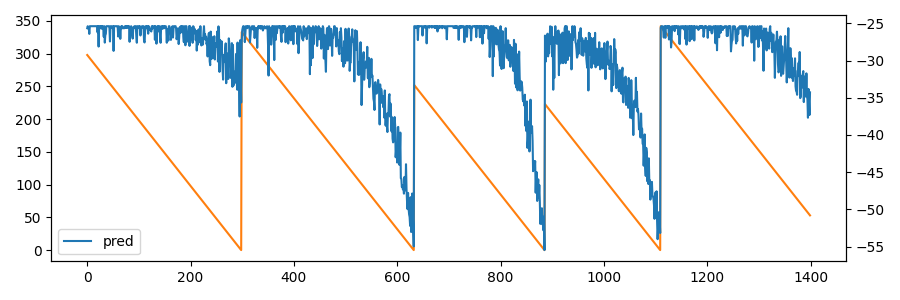

In [23]:
ts_pred = nn2.predict(ts_s[dt_in]).ravel() * trmaxrul
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

* We still have a decreasing trend, but with far less noise!
* The scale is however completely off

## The SBR Approach

**Let's try again using _both supervised and unsupervised data_:**

In [24]:
nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=1, beta=5, maxrul=trmaxrul, hidden=[32, 32])
batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32)
cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
nn2.compile(optimizer='Adam', run_eagerly=False)
history = nn2.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)

Epoch 1/20
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0163 - mse: 5.1203e-04 - cst: 0.0032
Epoch 2/20
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0028 - mse: 4.5211e-04 - cst: 4.6788e-04
Epoch 3/20
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0027 - mse: 4.3941e-04 - cst: 4.5228e-04
Epoch 4/20
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0026 - mse: 4.3346e-04 - cst: 4.2849e-04
Epoch 5/20
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0027 - mse: 4.3394e-04 - cst: 4.5322e-04
Epoch 6/20
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0024 - mse: 4.1775e-04 - cst: 4.0266e-04
Epoch 7/20
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0024 - mse: 4.1289e-04 - cst: 3.9451e-04
Epoch 8/20
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0023 - mse: 4.1979e-04 - cst: 3.8154e-04
Epoch 9/20
1350/1350 [==============================

## Inspecting the Predictions

**Let's have a look at the predictions on the _supervised_ data**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
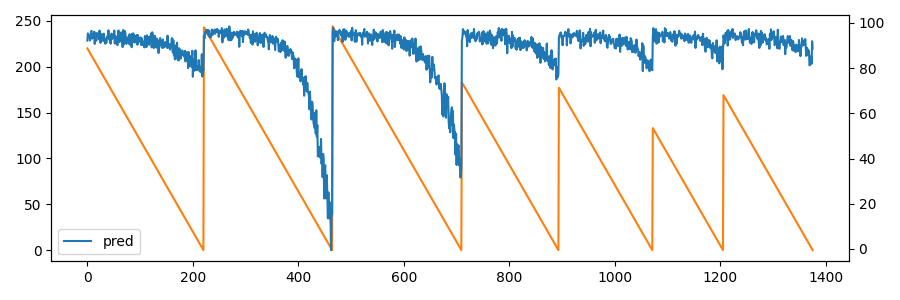

In [25]:
trs_pred = nn2.predict(trs_s[dt_in]).ravel() * trmaxrul
cst.plot_rul(trs_pred[:stop], trs["rul"].iloc[:stop], same_scale=False, figsize=figsize)

* The signal is _very stable_
* The scale is still off, but we can fix that with a well chosen threshold

## Inspecting the Predictions

**Then let's do the same for the _unsupervised_ data**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
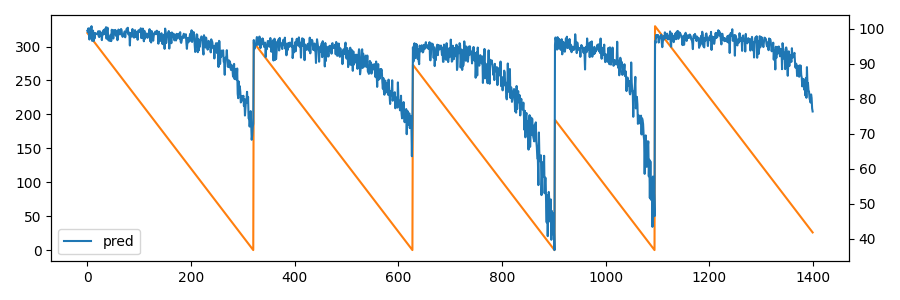

In [26]:
tru_pred = nn2.predict(tru_s[dt_in]).ravel() * trmaxrul
cst.plot_rul(tru_pred[:stop], tru["rul"].iloc[:stop], same_scale=False, figsize=figsize)

## Inspecting the Predictions

**Then let's do the same for the _test_ data**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
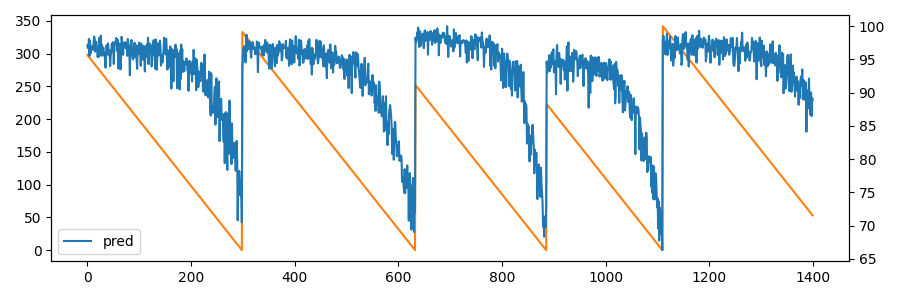

In [27]:
ts_pred = nn2.predict(ts_s[dt_in]).ravel() * trmaxrul
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

The behavior is more stable and consistent than before

## Threshold Optimization and Cost Evaluation

**We can now proceed with the threshold optimization (on the supervised data)**

Optimal threshold for the training set: 82


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
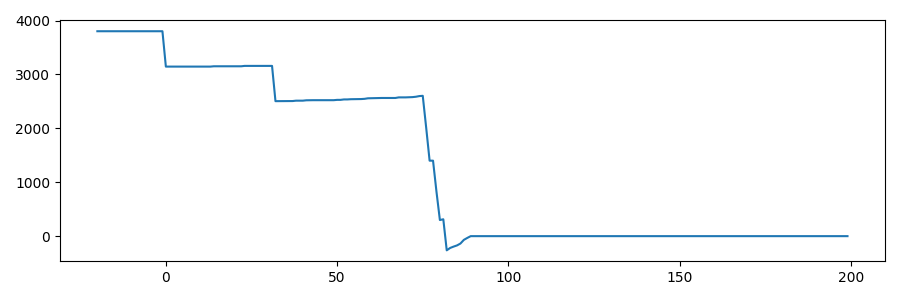

In [28]:
cmodel = cst.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(-20, 200)
trs_thr = cst.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {trs_thr}')

## Threshold Optimization and Cost Evaluation

**Finally, we can evaluate the SBR approach in terms of cost**

In [29]:
trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru_s['machine'].values, tru_pred, trs_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
print(f'Cost: {trs_c} (supervised), {tru_c} (unsupervised), {ts_c} (test)')

Cost: -263 (supervised), -9373 (unsupervised), -3580 (test)


In [62]:
print(f'Avg. fails: {trs_f/len(trs_mcn):.2f} (supervised), {tru_f/len(tru_mcn):.2f} (unsupervised), {ts_f/len(ts_mcn):.2f} (test)')
print(f'Avg. slack: {trs_sl/len(trs_mcn):.2f} (supervised), {tru_sl/len(tru_mcn):.2f} (unsupervised), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.00 (supervised), 0.02 (unsupervised), 0.02 (test)
Avg. slack: 43.57 (supervised), 56.06 (unsupervised), 58.30 (test)


* The number of fails has decreased very significantly
* The slack is still contained

And we did this with just a handful of run-to-failure experiments

## References

* [1] Diligenti, Michelangelo, Marco Gori, and Claudio Sacca. "Semantic-based regularization for learning and inference." Artificial Intelligence 244 (2017): 143-165.
* [2] Ferdinando Fioretto, Pascal Van Hentenryck, Terrence W. K. Mak, Cuong Tran, Federico Baldo, Michele Lombardi: Lagrangian Duality for Constrained Deep Learning. ECML/PKDD (5) 2020: 118-135